# DeepFalcon
### Common Task 1. Auto-encoder of the quark/gluon events

* Please train a variational auto-encoder to learn the representation based on three image channels (ECAL, HCAL and Tracks) for the dataset. 

* Please show a side-by-side comparison of original and reconstructed events. 


# Genie
### Common Task 1. Auto-encoder of the quark/gluon events

* Please train an auto-encoder to learn the representation based on three image channels (ECAL, HCAL and Tracks) for the dataset. 

* Please show a side-by-side comparison of original and reconstructed events. 


In [1]:
import torch
import numpy as np 
import h5py
import os
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
from tqdm.autonotebook import tqdm
import torchvision
import random
import cv2
import matplotlib.colors as colors

/tmp/ipykernel_81769/1228640743.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## SEEDING -  For Reproducability

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

## Data Preprocessing and Data Visualisation

In [3]:
data_path = 'quark-gluon_data-set_n139306.hdf5'


In [4]:
class Quark_Gluon_Dataset(torch.utils.data.Dataset):
    def __init__(self,root_path,num_samples= 10000,transform=None):
        self.root_path = root_path
        self.transform = transform
        self.num_samples = num_samples
        self.f = h5py.File(self.root_path,'r')
        self.data_length = len(self.f['y'][:num_samples]) # subset of samples due to limited computation

        self.X_jets = self.f['X_jets'][:num_samples]
        self.y = self.f['y'][:num_samples]
        
        if self.transform:
            self.X_jets = self.transform(torch.as_tensor(np.array(self.X_jets)).permute(0,3,1,2)) # BxHxWxC ----> BxCxHxW
        
    def __getitem__(self,idx):
        X_jets = self.X_jets[idx]           # images
        # mass = f['m0'][:1000][idx]        # mass
        # momentum = f['pt'][:1000][idx]    # transverse momentum
        y = self.y[idx]                     # labels

        return torch.as_tensor(np.array(X_jets)),torch.as_tensor(np.array(y))

    def __len__(self):
        return self.data_length

In [5]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((128,128))])
data = Quark_Gluon_Dataset(data_path,transform=transform,num_samples=12000)
train_data,valid_data,test_data = torch.utils.data.random_split(dataset=data,lengths=[0.7,0.2,0.1],generator=g)

batch_size = 256
train_dataloader = torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size,num_workers=1,
                                         shuffle=True, worker_init_fn=seed_worker,generator=g)
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_data,batch_size=batch_size,num_workers=1,
                                         shuffle=False, worker_init_fn=seed_worker,generator=g)

test_dataloader = torch.utils.data.DataLoader(dataset=test_data,batch_size=batch_size,num_workers=1,
                                         shuffle=False, worker_init_fn=seed_worker,generator=g)

/home/pratyush/miniconda3/envs/clip/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [6]:
X_jets,y = next(iter(train_dataloader))
X_jets.shape

torch.Size([256, 3, 128, 128])

### VISUALISING A SAMPLE FROM TRAIN_DATA

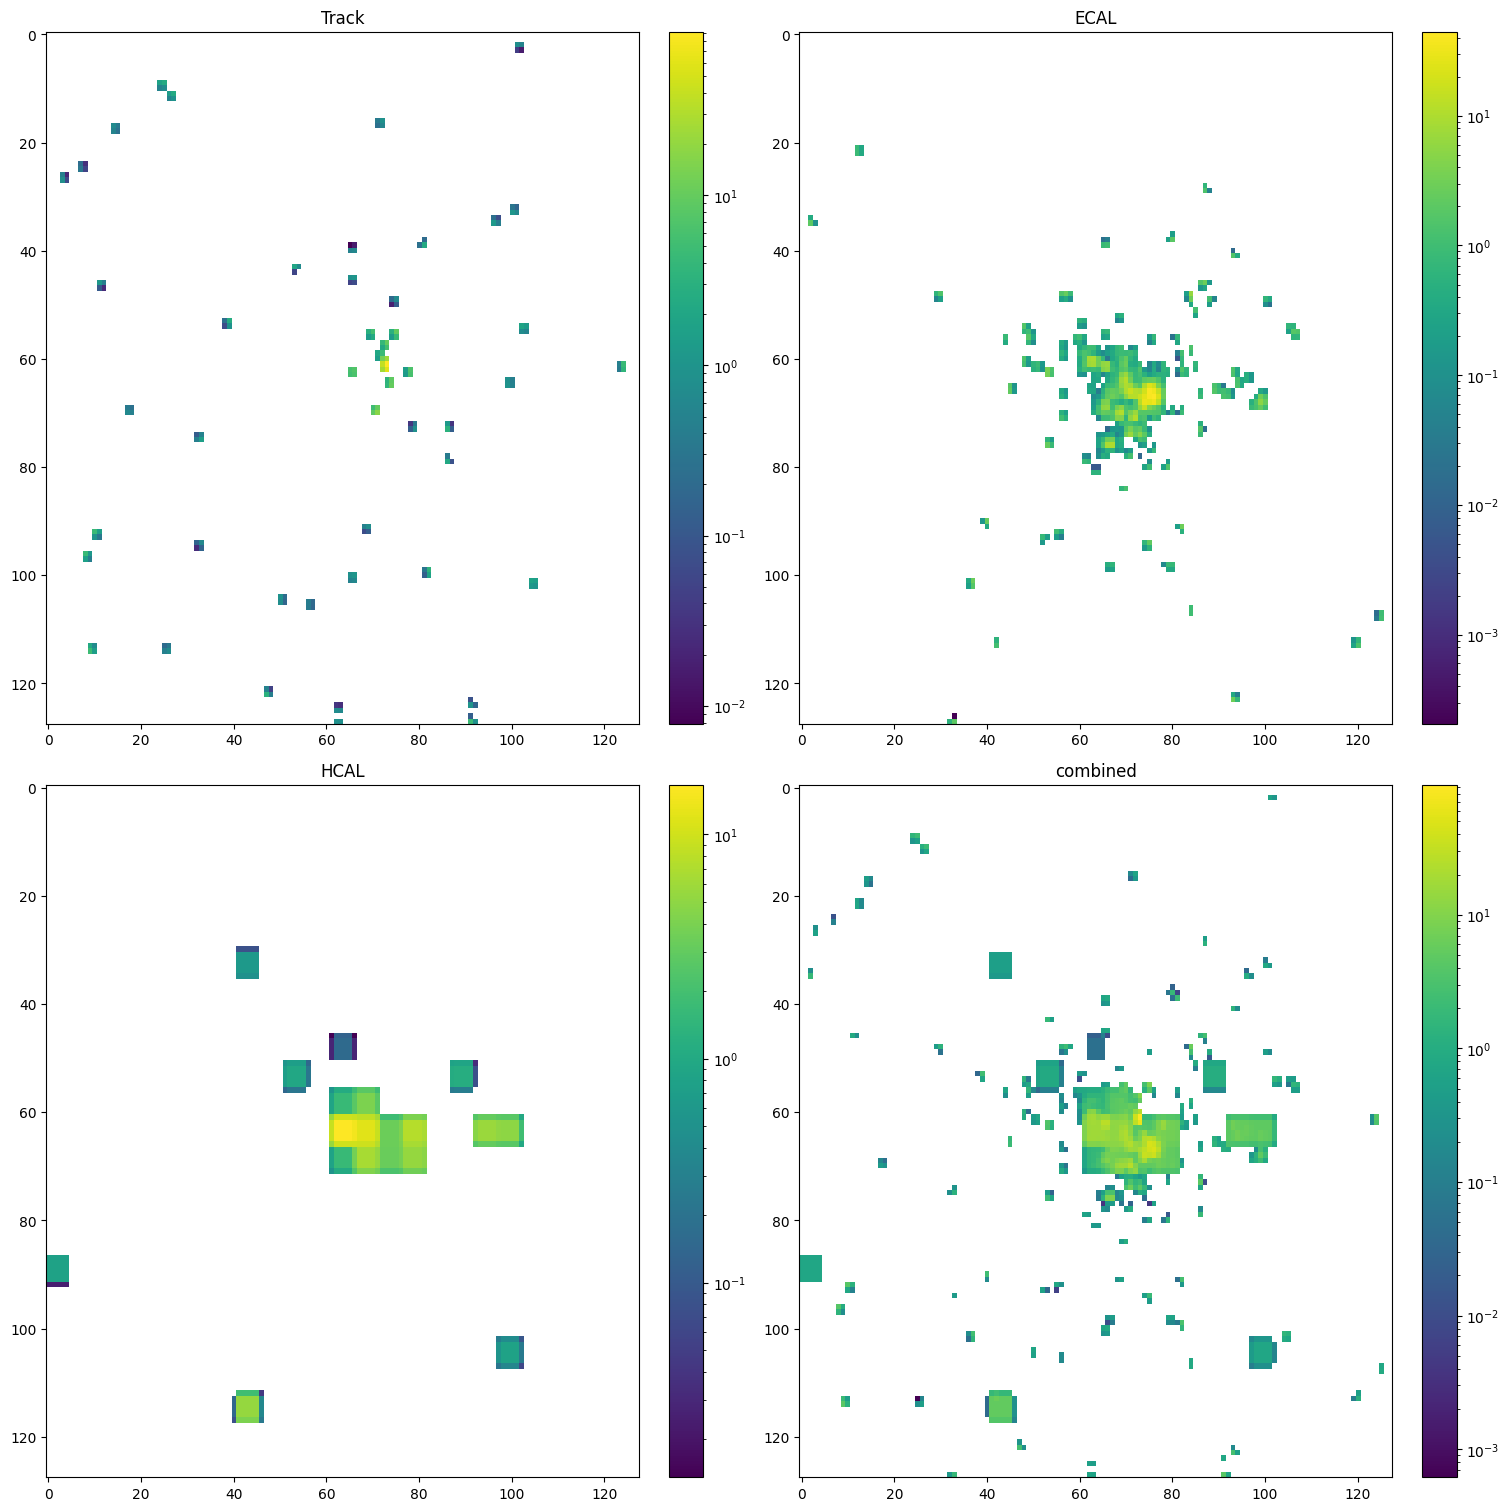

In [7]:
i = 10

mean_track = torch.mean(X_jets[i][0,:,:])
std_track = torch.std(X_jets[i][0,:,:])

mean_ecal = torch.mean(X_jets[i][1,:,:])
std_ecal = torch.std(X_jets[i][1,:,:])

mean_hcal = torch.mean(X_jets[i][2,:,:])
std_hcal = torch.std(X_jets[i][2,:,:])

tracks = (X_jets[i][0,:,:] - mean_track) / std_track
ecal = (X_jets[i][1,:,:] - mean_ecal) / std_ecal
hcal = (X_jets[i][2,:,:] - mean_hcal) / std_hcal

combined = tracks + ecal + hcal

fig, axs = plt.subplots(2, 2, figsize=(15, 15), constrained_layout=True)

im_tracks = axs[0,0].imshow(tracks,aspect='auto', norm=colors.LogNorm())
axs[0,0].set_title('Track')
fig.colorbar(im_tracks, ax=axs[0,0])

im_ecal = axs[0,1].imshow(ecal,aspect='auto', norm=colors.LogNorm())
axs[0,1].set_title('ECAL')
fig.colorbar(im_ecal, ax=axs[0,1])

im_hcal = axs[1,0].imshow(hcal,  aspect='auto', norm=colors.LogNorm())
axs[1,0].set_title('HCAL')
fig.colorbar(im_hcal, ax=axs[1,0])

im_combined = axs[1,1].imshow(combined,aspect='auto', norm=colors.LogNorm())
axs[1,1].set_title('combined')
fig.colorbar(im_combined, ax=axs[1,1])

plt.show()


# MODELS 


## 1) AutoEncoder

In [27]:
class AutoEncoder(nn.Module):
    def __init__(self,input_channels:int =3, base_channel_size:int = 32, latent_dim:int = 1024, act_fn:object = nn.PReLU):

        super().__init__()
        c_hid = base_channel_size
        self.encoder_net = nn.Sequential(
            nn.Conv2d( input_channels, c_hid, kernel_size=3, padding=1, stride=2,bias=False), #[B,3,128,128]---> [B,c_hid,64,64]
            act_fn(num_parameters = c_hid), 
            nn.Conv2d(c_hid,c_hid,kernel_size=3,padding=1,bias=False), #[B,c_hid,64,64] ---> [B,c_hid,64,64]
            act_fn(num_parameters = c_hid),
            nn.Conv2d(c_hid,2*c_hid,kernel_size=3,padding=1,stride=2,bias=False) , #[B,c_hid,64,64] ---> [B,2*c_hid,32,32]
            act_fn(num_parameters = 2*c_hid), 
            nn.Flatten(), #[B,2*c_hid,32,32] ---> [B,2*32*32*c_hid]
            ) 
        

        self.decoder_net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid,2*c_hid,kernel_size=3,output_padding=1,padding=1,stride=2,bias=False), #[B,2*c_hid,32,32] --->[B,2*c_hid,64,64]
            act_fn(num_parameters = 2*c_hid),
            nn.Conv2d(2*c_hid,c_hid,kernel_size=3,padding=1,bias=False), #[B,2*c_hid,64,64] ---> [B,c_hid,64,64]
            act_fn(num_parameters = c_hid),
            nn.ConvTranspose2d(c_hid,input_channels,kernel_size=3,output_padding=1,padding=1,stride=2,bias=False),#[B,c_hid.64.64] ---> [B,3,128,128]
            nn.Sigmoid()
            )
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self,x):
        x = self.encoder_net(x)
        x = x.reshape(x.shape[0],-1,32,32) #[B,2*32*32*c_hid] ---> [B,2*c_hid,32,32]
        x = self.decoder_net(x)
        return x



In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =  AutoEncoder(latent_dim=1024).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
def ae_loss(x,xhat):
    reconstruction_loss = F.binary_cross_entropy(xhat,x,reduction='sum')
    return reconstruction_loss

In [29]:
num_epochs = 50
for epoch in range(num_epochs):
    total_train_loss = 0
    total_valid_loss = 0


    model.train()
    for x_jets_train , labels in tqdm(train_dataloader,total = len(train_dataloader)):
        x_jets_train = x_jets_train.to(device)

        optimizer.zero_grad()
        
        x_hat_train = model(x_jets_train)
        train_loss = ae_loss(x_jets_train,x_hat_train)
        
        train_loss.backward()
        optimizer.step()

        total_train_loss+=train_loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)

    model.eval()
    with torch.no_grad():
        for x_jets_valid , labels in tqdm(valid_dataloader,total = len(valid_dataloader)):
            x_jets_valid = x_jets_valid.to(device)

            x_hat_valid = model(x_jets_valid)
            valid_loss = ae_loss(x_jets_valid,x_hat_valid)

            total_valid_loss += valid_loss.item()

    avg_valid_loss = total_valid_loss / len(valid_dataloader)

    torch.cuda.empty_cache()

    if (epoch+1)%5==0:
        print(f'epoch: {epoch+1}, train_loss: {avg_train_loss},valid_loss: {avg_valid_loss}')


100%|██████████| 10/10 [00:00<00:00, 18.54it/s]


epoch: 5, train_loss: 1585353.5265151516,valid_loss: 1488996.35


100%|██████████| 10/10 [00:00<00:00, 19.41it/s]


epoch: 10, train_loss: 1440754.4621212122,valid_loss: 1375924.53125


100%|██████████| 10/10 [00:00<00:00, 17.63it/s]


epoch: 15, train_loss: 1401695.0151515151,valid_loss: 1342342.4375


100%|██████████| 10/10 [00:00<00:00, 18.34it/s]


epoch: 20, train_loss: 1384348.893939394,valid_loss: 1326917.375


100%|██████████| 10/10 [00:00<00:00, 17.18it/s]


epoch: 25, train_loss: 1374793.253787879,valid_loss: 1318237.0375


100%|██████████| 10/10 [00:00<00:00, 16.23it/s]


epoch: 30, train_loss: 1368827.625,valid_loss: 1312752.79375


100%|██████████| 10/10 [00:00<00:00, 16.61it/s]


epoch: 35, train_loss: 1364794.3863636365,valid_loss: 1309009.225


100%|██████████| 10/10 [00:00<00:00, 17.22it/s]


epoch: 40, train_loss: 1361913.6590909092,valid_loss: 1306317.13125


100%|██████████| 10/10 [00:00<00:00, 17.26it/s]


epoch: 45, train_loss: 1359773.0681818181,valid_loss: 1304308.140625


100%|██████████| 10/10 [00:00<00:00, 16.68it/s]

epoch: 50, train_loss: 1358134.0454545454,valid_loss: 1302763.771875


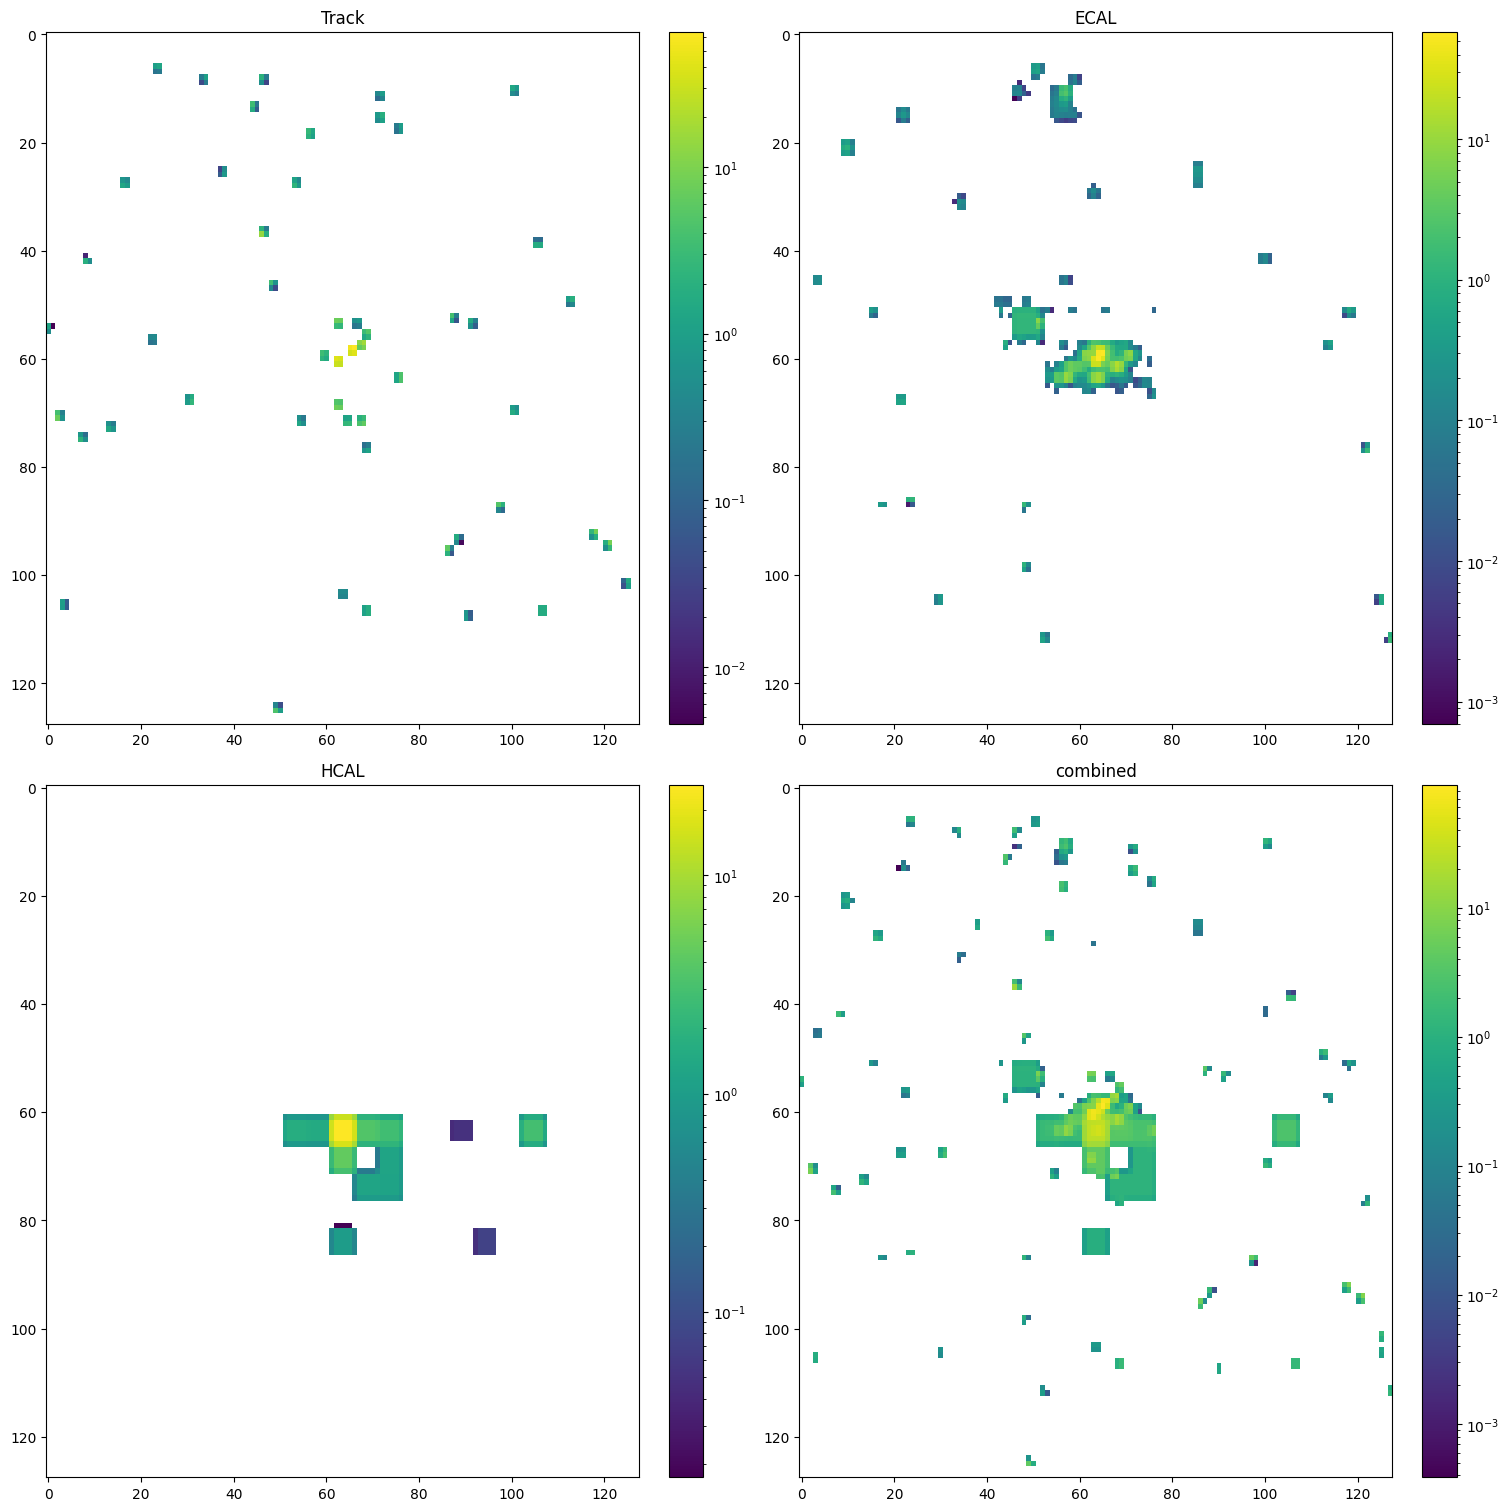

In [30]:
test_X_jets, _ = next(iter(test_dataloader))

i = 10

mean_track = torch.mean(test_X_jets[i][0,:,:])
std_track = torch.std(test_X_jets[i][0,:,:])

mean_ecal = torch.mean(test_X_jets[i][1,:,:])
std_ecal = torch.std(test_X_jets[i][1,:,:])

mean_hcal = torch.mean(test_X_jets[i][2,:,:])
std_hcal = torch.std(test_X_jets[i][2,:,:])

tracks = (test_X_jets[i][0,:,:] - mean_track) / std_track
ecal = (test_X_jets[i][1,:,:] - mean_ecal) / std_ecal
hcal = (test_X_jets[i][2,:,:] - mean_hcal) / std_hcal

combined = tracks + ecal + hcal

fig, axs = plt.subplots(2, 2, figsize=(15, 15), constrained_layout=True)

im_tracks = axs[0,0].imshow(tracks,aspect='auto', norm=colors.LogNorm())
axs[0,0].set_title('Track') 
fig.colorbar(im_tracks, ax=axs[0,0])

im_ecal = axs[0,1].imshow(ecal,aspect='auto', norm=colors.LogNorm())
axs[0,1].set_title('ECAL')
fig.colorbar(im_ecal, ax=axs[0,1])

im_hcal = axs[1,0].imshow(hcal,  aspect='auto', norm=colors.LogNorm())
axs[1,0].set_title('HCAL')
fig.colorbar(im_hcal, ax=axs[1,0])

im_combined = axs[1,1].imshow(combined,aspect='auto', norm=colors.LogNorm())
axs[1,1].set_title('combined')
fig.colorbar(im_combined, ax=axs[1,1])

plt.show()


In [31]:
model.eval()
total_test_loss = 0
with torch.no_grad():
    for x_jets_test , labels in tqdm(test_dataloader,total = len(test_dataloader)):
            x_jets_test = x_jets_test.to(device)

            x_hat_test = model(x_jets_test)
            test_loss = ae_loss(x_jets_test,x_hat_test)
            total_test_loss += test_loss.item()
    avg_test_loss = total_test_loss / len(test_dataloader)
    print(avg_test_loss)


100%|██████████| 5/5 [00:00<00:00, 13.84it/s]

1292576.025


In [32]:
model.eval()
with torch.inference_mode():
    test_img_pred = model(test_X_jets.to(device))

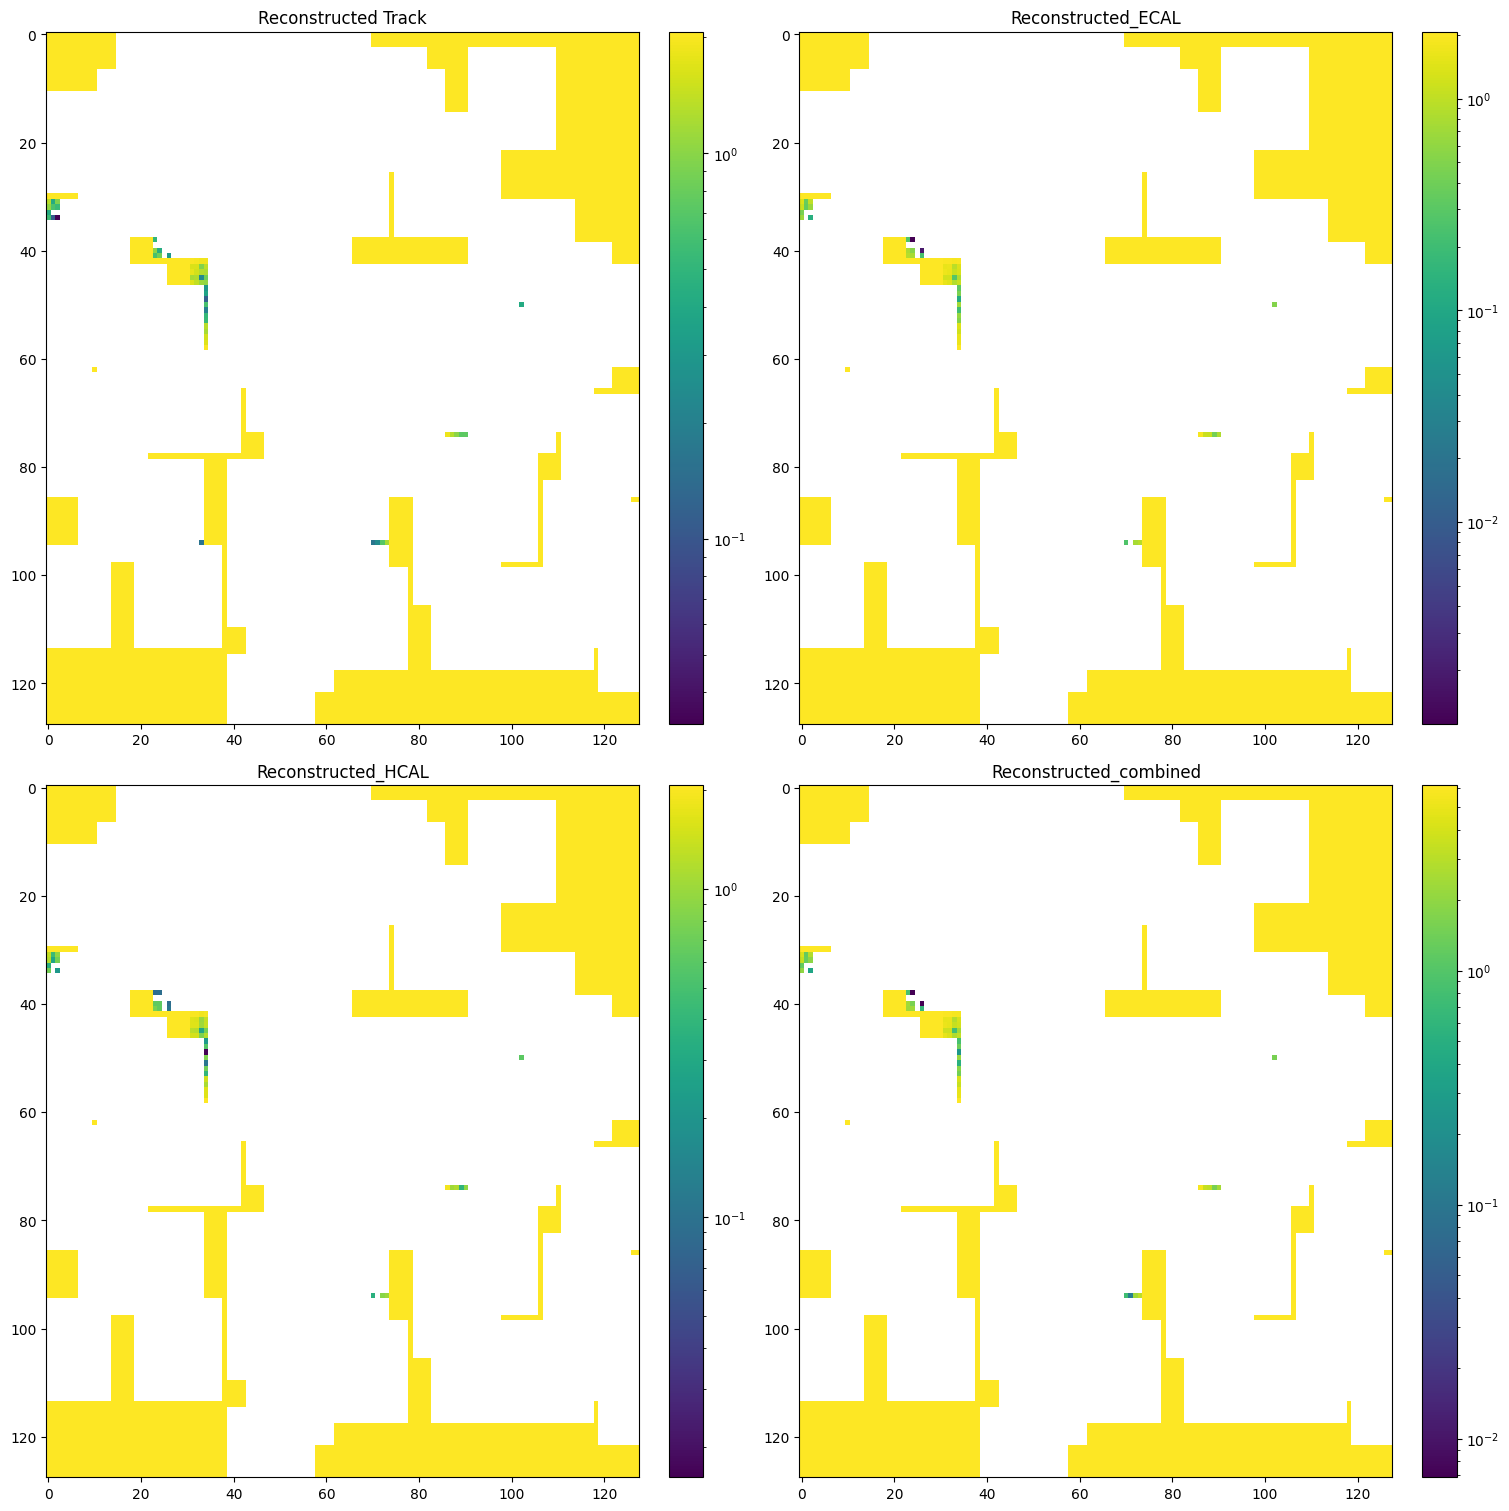

In [33]:
i = 10

mean_track = torch.mean(test_img_pred[i][0,:,:])
std_track = torch.std(test_img_pred[i][0,:,:])

mean_ecal = torch.mean(test_img_pred[i][1,:,:])
std_ecal = torch.std(test_img_pred[i][1,:,:])

mean_hcal = torch.mean(test_img_pred[i][2,:,:])
std_hcal = torch.std(test_img_pred[i][2,:,:])

tracks = (test_img_pred[i][0,:,:] - mean_track) / std_track
ecal = (test_img_pred[i][1,:,:] - mean_ecal) / std_ecal
hcal = (test_img_pred[i][2,:,:] - mean_hcal) / std_hcal

combined = tracks + ecal + hcal

fig, axs = plt.subplots(2, 2, figsize=(15, 15), constrained_layout=True)

im_tracks = axs[0,0].imshow(tracks.detach().cpu(),aspect='auto', norm=colors.LogNorm())
axs[0,0].set_title('Reconstructed Track')
fig.colorbar(im_tracks, ax=axs[0,0])

im_ecal = axs[0,1].imshow(ecal.detach().cpu(),aspect='auto', norm=colors.LogNorm())
axs[0,1].set_title('Reconstructed_ECAL')
fig.colorbar(im_ecal, ax=axs[0,1])

im_hcal = axs[1,0].imshow(hcal.detach().cpu(),  aspect='auto', norm=colors.LogNorm())
axs[1,0].set_title('Reconstructed_HCAL')
fig.colorbar(im_hcal, ax=axs[1,0])

im_combined = axs[1,1].imshow(combined.detach().cpu(),aspect='auto', norm=colors.LogNorm())
axs[1,1].set_title('Reconstructed_combined')
fig.colorbar(im_combined, ax=axs[1,1])

plt.show()


## 2) Variational AutoEncoder


In [17]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self,input_channels:int =3, base_channel_size:int = 32, latent_dim:int = 1024, act_fn:object = nn.PReLU):

        super().__init__()
        c_hid = base_channel_size
        self.encoder_net = nn.Sequential(
            nn.Conv2d( input_channels, c_hid, kernel_size=3, padding=1, stride=2,bias=False), #[B,3,128,128]---> [B,c_hid,64,64]
            act_fn(num_parameters = c_hid), 
            nn.Conv2d(c_hid,c_hid,kernel_size=3,padding=1,bias=False), #[B,c_hid,64,64] ---> [B,c_hid,64,64]
            act_fn(num_parameters = c_hid),
            nn.Conv2d(c_hid,2*c_hid,kernel_size=3,padding=1,stride=2,bias=False) , #[B,c_hid,64,64] ---> [B,2*c_hid,32,32]
            act_fn(num_parameters = 2*c_hid), 
            nn.Flatten(), #[B,2*c_hid,32,32] ---> [B,2*32*32*c_hid]
            ) 
        
        self.fc_mu = nn.Linear(2*32*32*c_hid,latent_dim)
        self.fc_logvar = nn.Linear(2*32*32*c_hid,latent_dim)

        self.linear = nn.Sequential(nn.Linear(latent_dim,2*32*32*c_hid,bias=False),act_fn()) #[B,latent_dim] ---> [B,2*32*32*c_hid]

        self.decoder_net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid,2*c_hid,kernel_size=3,output_padding=1,padding=1,stride=2,bias=False), #[B,2*c_hid,32,32] --->[B,2*c_hid,64,64]
            act_fn(num_parameters = 2*c_hid),
            nn.Conv2d(2*c_hid,c_hid,kernel_size=3,padding=1,bias=False), #[B,2*c_hid,64,64] ---> [B,c_hid,64,64]
            act_fn(num_parameters = c_hid),
            nn.ConvTranspose2d(c_hid,input_channels,kernel_size=3,output_padding=1,padding=1,stride=2,bias=False),#[B,c_hid.64.64] ---> [B,3,128,128]
            nn.Sigmoid()
            )
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def reparametrize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self,x):
        x = self.encoder_net(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparametrize(mu,logvar)
        x = self.linear(z)
        x = x.reshape(x.shape[0],-1,32,32) #[B,2*32*32*c_hid] ---> [B,2*c_hid,32,32]
        x = self.decoder_net(x)
        return x,mu,logvar

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VariationalAutoEncoder(latent_dim=1024).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)


def vae_loss (x,xhat,mu,logvar):
    # reconstruction_loss = F.mse_loss(xhat,x,reduction='sum')
    reconstruction_loss = F.binary_cross_entropy(xhat,x,reduction='sum')
    # reconstruction_loss = sigmoid_focal_loss(xhat,x,reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # print(f'reconstruction_{reconstruction_loss}')
    # print(f'kl_divergence_{kl_divergence}')
    return reconstruction_loss + 1*kl_divergence

In [19]:
num_epochs = 50
for epoch in range(num_epochs):
    total_train_loss = 0
    total_valid_loss = 0


    model.train()
    for x_jets_train , labels in tqdm(train_dataloader,total = len(train_dataloader)):
        x_jets_train = x_jets_train.to(device)

        optimizer.zero_grad()
        
        x_hat_train,mu_train,logvar_train = model(x_jets_train)
        train_loss = vae_loss(x_jets_train,x_hat_train,mu_train,logvar_train)
        
        train_loss.backward()
        optimizer.step()

        total_train_loss+=train_loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)

    model.eval()
    with torch.no_grad():
        for x_jets_valid , labels in tqdm(valid_dataloader,total = len(valid_dataloader)):
            x_jets_valid = x_jets_valid.to(device)

            x_hat_valid,mu_valid,logvar_valid = model(x_jets_valid)
            valid_loss = vae_loss(x_jets_valid,x_hat_valid,mu_valid,logvar_valid)

            total_valid_loss += valid_loss.item()

    avg_valid_loss = total_valid_loss / len(valid_dataloader)

    torch.cuda.empty_cache()

    if (epoch+1)%5 ==0:
        print(f'epoch: {epoch+1}, train_loss: {avg_train_loss},valid_loss: {avg_valid_loss}')


100%|██████████| 10/10 [00:00<00:00, 15.78it/s]


epoch: 5, train_loss: 19826.513731060608,valid_loss: 17839.729541015626


100%|██████████| 10/10 [00:00<00:00, 15.71it/s]


epoch: 10, train_loss: 15995.38583096591,valid_loss: 13905.283154296874


100%|██████████| 10/10 [00:00<00:00, 11.22it/s]


epoch: 15, train_loss: 13386.508049242424,valid_loss: 11788.036962890625


100%|██████████| 10/10 [00:00<00:00, 15.35it/s]


epoch: 20, train_loss: 12091.1162109375,valid_loss: 10375.75732421875


100%|██████████| 10/10 [00:00<00:00, 15.28it/s]


epoch: 25, train_loss: 10825.706498579546,valid_loss: 9566.634545898438


100%|██████████| 10/10 [00:00<00:00, 14.83it/s]


epoch: 30, train_loss: 10061.13905658144,valid_loss: 8985.322705078124


100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


epoch: 35, train_loss: 9133.05918560606,valid_loss: 8291.2099609375


100%|██████████| 10/10 [00:00<00:00, 15.03it/s]


epoch: 40, train_loss: 8377.337550307766,valid_loss: 7675.403247070312


100%|██████████| 10/10 [00:00<00:00, 15.59it/s]


epoch: 45, train_loss: 7850.2333984375,valid_loss: 7231.53994140625


100%|██████████| 10/10 [00:02<00:00,  4.80it/s]

epoch: 50, train_loss: 7623.828554095644,valid_loss: 6950.908178710937


In [20]:

test_X_jets, _ = next(iter(test_dataloader))

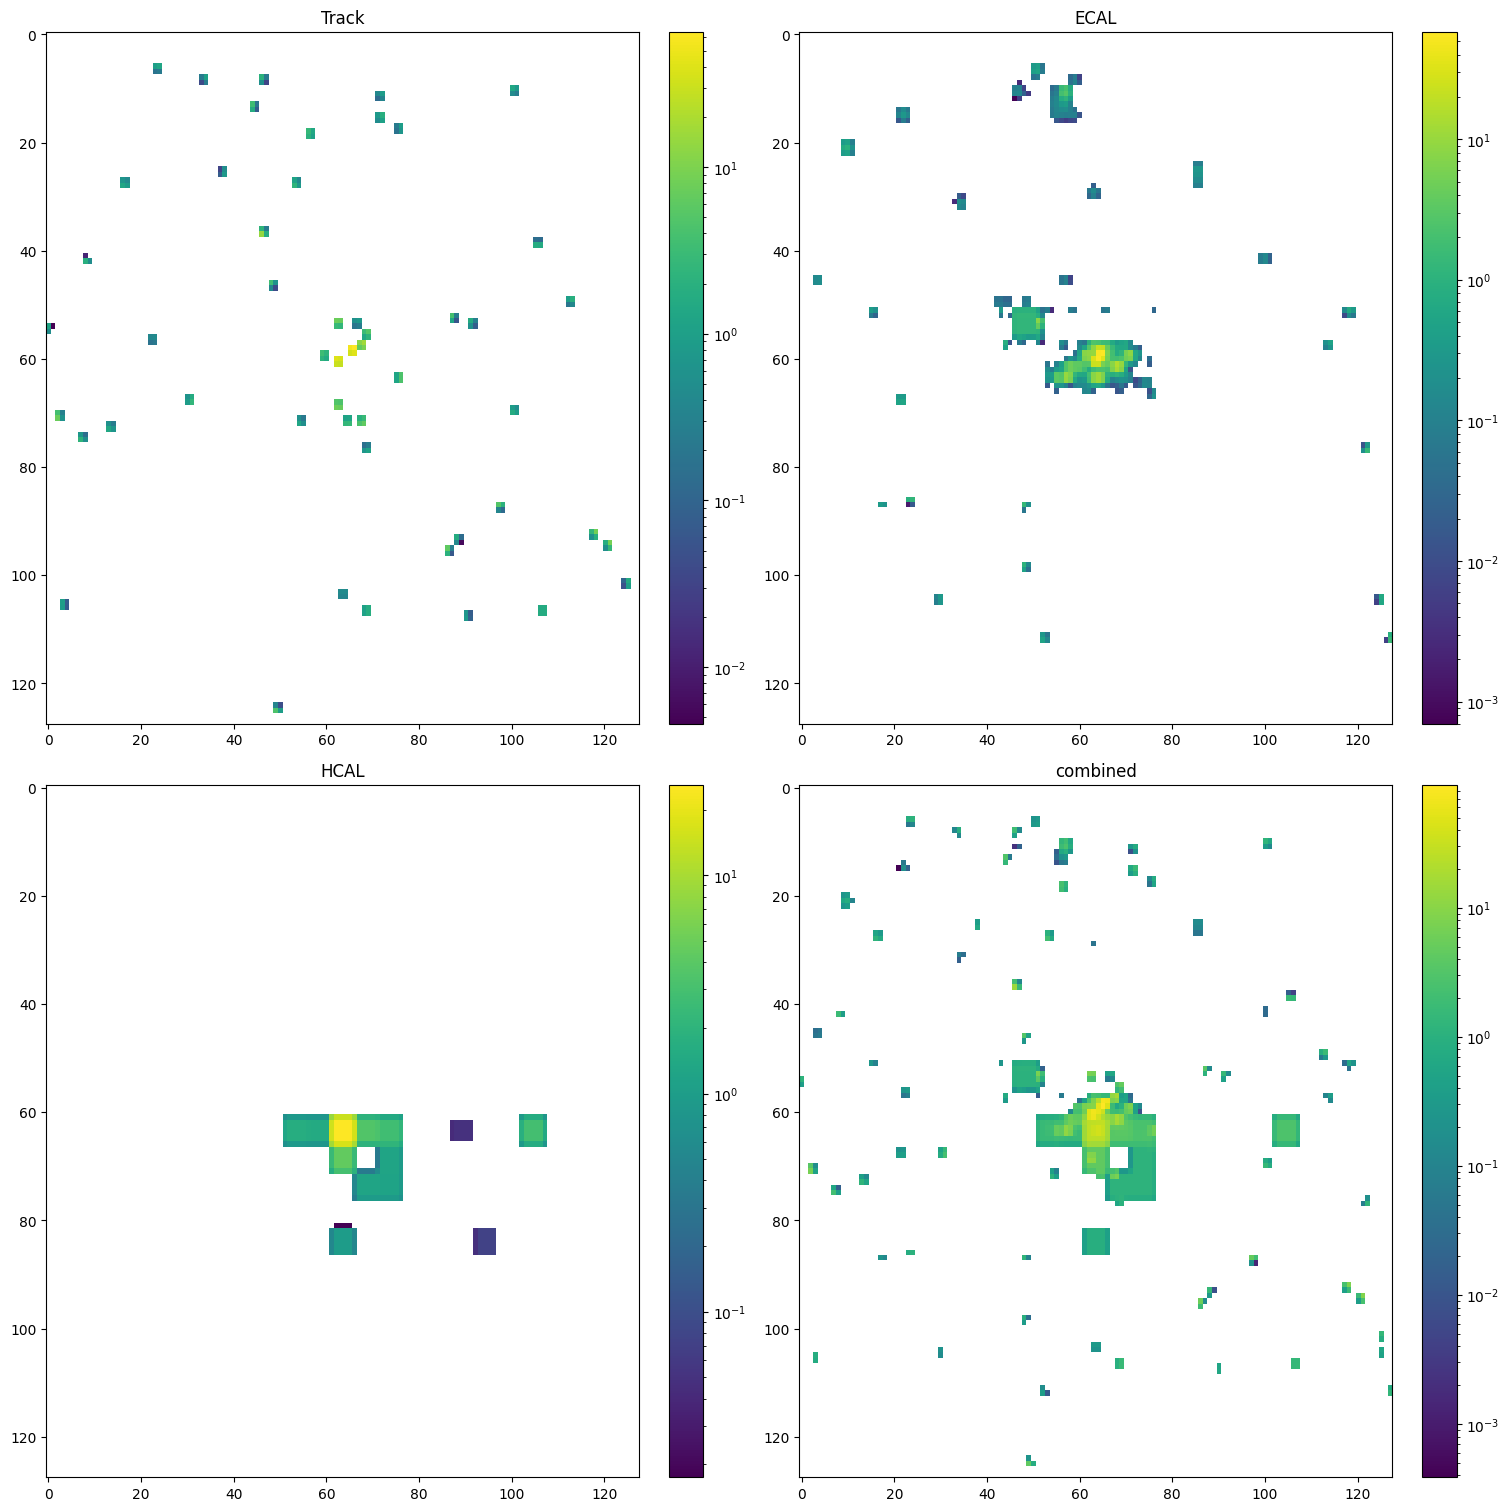

In [21]:
i = 10

mean_track = torch.mean(test_X_jets[i][0,:,:])
std_track = torch.std(test_X_jets[i][0,:,:])

mean_ecal = torch.mean(test_X_jets[i][1,:,:])
std_ecal = torch.std(test_X_jets[i][1,:,:])

mean_hcal = torch.mean(test_X_jets[i][2,:,:])
std_hcal = torch.std(test_X_jets[i][2,:,:])

tracks = (test_X_jets[i][0,:,:] - mean_track) / std_track
ecal = (test_X_jets[i][1,:,:] - mean_ecal) / std_ecal
hcal = (test_X_jets[i][2,:,:] - mean_hcal) / std_hcal

combined = tracks + ecal + hcal

fig, axs = plt.subplots(2, 2, figsize=(15, 15), constrained_layout=True)

im_tracks = axs[0,0].imshow(tracks,aspect='auto', norm=colors.LogNorm())
axs[0,0].set_title('Track') 
fig.colorbar(im_tracks, ax=axs[0,0])

im_ecal = axs[0,1].imshow(ecal,aspect='auto', norm=colors.LogNorm())
axs[0,1].set_title('ECAL')
fig.colorbar(im_ecal, ax=axs[0,1])

im_hcal = axs[1,0].imshow(hcal,  aspect='auto', norm=colors.LogNorm())
axs[1,0].set_title('HCAL')
fig.colorbar(im_hcal, ax=axs[1,0])

im_combined = axs[1,1].imshow(combined,aspect='auto', norm=colors.LogNorm())
axs[1,1].set_title('combined')
fig.colorbar(im_combined, ax=axs[1,1])

plt.show()


In [22]:
model.eval()
total_test_loss = 0
with torch.no_grad():
    for x_jets_test , labels in tqdm(test_dataloader,total = len(test_dataloader)):
            x_jets_test = x_jets_test.to(device)

            x_hat_test,mu_test,logvar_test = model(x_jets_test)
            test_loss = vae_loss(x_jets_test,x_hat_test,mu_test,logvar_test)
            total_test_loss += test_loss.item()
    avg_test_loss = total_test_loss / len(test_dataloader)
    print(avg_test_loss)


100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

7080.3193359375


In [23]:
model.eval()
with torch.inference_mode():
    test_img_pred,mu_pred,logvar_pred = model(test_X_jets.to(device))

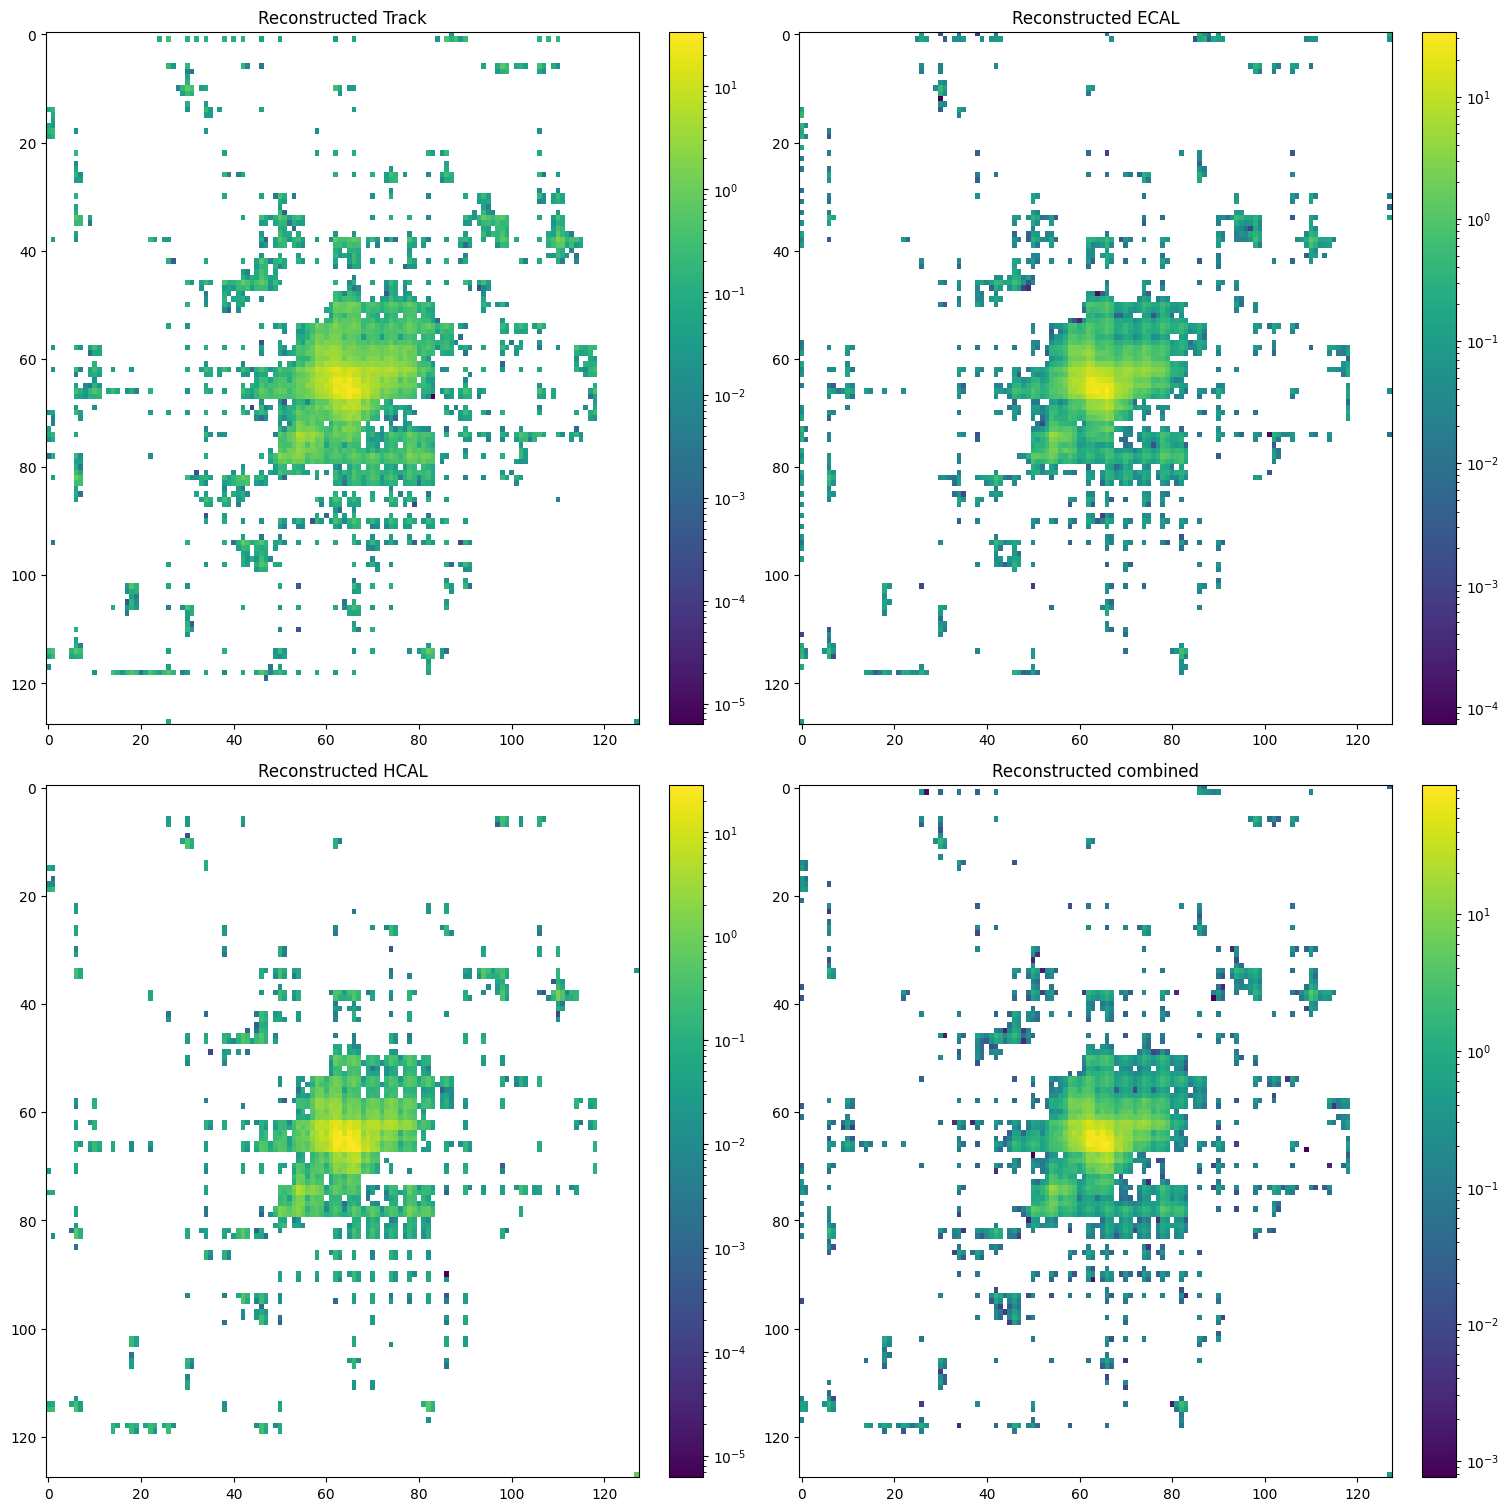

In [25]:
i = 10

mean_track = torch.mean(test_img_pred[i][0,:,:])
std_track = torch.std(test_img_pred[i][0,:,:])

mean_ecal = torch.mean(test_img_pred[i][1,:,:])
std_ecal = torch.std(test_img_pred[i][1,:,:])

mean_hcal = torch.mean(test_img_pred[i][2,:,:])
std_hcal = torch.std(test_img_pred[i][2,:,:])

tracks = (test_img_pred[i][0,:,:] - mean_track) / std_track
ecal = (test_img_pred[i][1,:,:] - mean_ecal) / std_ecal
hcal = (test_img_pred[i][2,:,:] - mean_hcal) / std_hcal

combined = tracks + ecal + hcal

fig, axs = plt.subplots(2, 2, figsize=(15, 15), constrained_layout=True)

im_tracks = axs[0,0].imshow(tracks.detach().cpu(),aspect='auto', norm=colors.LogNorm())
axs[0,0].set_title('Reconstructed Track')
fig.colorbar(im_tracks, ax=axs[0,0])

im_ecal = axs[0,1].imshow(ecal.detach().cpu(),aspect='auto', norm=colors.LogNorm())
axs[0,1].set_title('Reconstructed ECAL')
fig.colorbar(im_ecal, ax=axs[0,1])

im_hcal = axs[1,0].imshow(hcal.detach().cpu(),  aspect='auto', norm=colors.LogNorm())
axs[1,0].set_title('Reconstructed HCAL')
fig.colorbar(im_hcal, ax=axs[1,0])

im_combined = axs[1,1].imshow(combined.detach().cpu(),aspect='auto', norm=colors.LogNorm())
axs[1,1].set_title('Reconstructed combined')
fig.colorbar(im_combined, ax=axs[1,1])

plt.show()


## DISCUSSION


* As the data doesn't contain normal RGB channels and instead has different channels like ECAL,HCAL,Tracks ,data preprocessing needs to be chosen carefully

* Model architecture might not be too complex to extract the patterns in the underlying data

* Since Images are highly structured data, the pixels are arranged in a meaningful way. If the way pixels are arranged changes then we lose the meaning , hence here convolutions may not work as we aren't dealing with our normal RGB channels image data.

* Instead working with other type of data like graphs (aka Graph Neural Networks) would give better results by extracting features in the graphical representation of the given images.